In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
BASE = '/content/gdrive/My Drive/nlp-data/'

In [0]:
from fastai.text import *
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [0]:
def join_text(row):
    title, abstract = row.title, row.abstract
    return title + '\n' + abstract

In [0]:
df = pd.read_csv(BASE + 'labeled.tsv', sep='\t')
df['text'] = df.apply(join_text, axis=1)
df = df[['label', 'text']]

In [0]:
df_trn, df_val = train_test_split(df, stratify=df['label'], test_size=0.2)

df_trn.shape, df_val.shape

((407, 2), (102, 2))

In [0]:
data_lm = load_data(BASE, 'data_lm_export_50000.pkl')

In [0]:
ls /content/gdrive/My\ Drive/nlp-data

class-export              data_lm_export_5000.pkl  ft_enc_5000.pth
data_class_export.pkl     data_lm_export.pkl       labeled.tsv
data_lm_export_50000.pkl  ft_enc_50000.pth         models/
data_lm_export_5000a.pkl  ft_enc_5000a.pth         unlabeled.tsv


In [0]:
# Classifier model data
data_class = TextClasDataBunch.from_df(train_df=df_trn, valid_df=df_val, path="", vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
data_lm.save(BASE+'data_lm_export-50k.pkl')
data_class.save(BASE+'data_class_export-50k.pkl')

data_lm = load_data(BASE, 'data_lm_export-50k.pkl')
data_class = load_data(BASE, 'data_class_export-50k.pkl', bs=64)

In [0]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(BASE+'ft_enc_50000')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (407 items)
x: TextList
xxbos xxmaj machine xxmaj learning for high speed channel optimization 
  xxmaj design of printed circuit board ( xxup pcb ) stack - up requires the consideration of characteristic impedance , insertion loss and crosstalk . xxmaj as there are many parameters in a xxup pcb stack - up design , the optimization of these parameters needs to be efficient and accurate . a less optimal stack - up would lead to expensive xxup pcb material choices in high speed designs . xxmaj in this paper , an efficient global optimization method using parallel and intelligent xxmaj bayesian optimization is proposed for the stripline design .,xxbos rllib : xxmaj abstractions for xxmaj distributed xxmaj reinforcement xxmaj learning 
  xxmaj reinforcement learning ( xxup rl ) algorithms involve the deep nesting of highly irregular computation patterns , each of which typically exhibits opportunities for distributed computation . xxmaj 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 4.37E-02


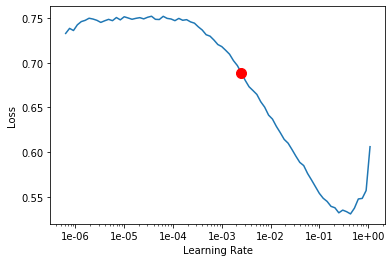

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
%%time 
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(BASE+'ft_enc_50000')

learn.fit_one_cycle(3, min_grad_lr)

learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(5e-3, 2e-3), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.783970,0.681297,0.637255,00:02
1,0.667022,0.658523,0.607843,00:02
2,0.597052,0.621179,0.745098,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.468189,0.572744,0.764706,00:02
1,0.413842,0.522750,0.784314,00:02
2,0.363576,0.491882,0.784314,00:02


CPU times: user 9.83 s, sys: 5.93 s, total: 15.8 s
Wall time: 17 s


In [0]:
%%time 
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(BASE+'ft_enc_50000')

learn.fit_one_cycle(3, min_grad_lr)

learn.freeze_to(-2)
learn.fit_one_cycle(6, slice(5e-3, 2e-3), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.745193,0.653865,0.617647,00:02
1,0.635072,0.627128,0.627451,00:02
2,0.559743,0.603466,0.696078,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.421024,0.570569,0.705882,00:02
1,0.395548,0.525975,0.764706,00:02
2,0.368849,0.499072,0.735294,00:02
3,0.325224,0.481785,0.774510,00:02
4,0.286179,0.469038,0.794118,00:02
5,0.254780,0.465940,0.833333,00:02


CPU times: user 14.9 s, sys: 9.26 s, total: 24.1 s
Wall time: 25.7 s


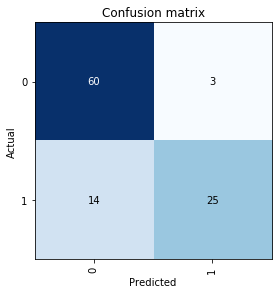

In [0]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
learn.export(BASE+'class-export-50k-a')